## Scoping for Part 3:
Owner:  Leana

3.  An update of the table “Opportunity Youth Status by Age” located on page 2 of the 2016 report “Opportunity Youth in the Road Map Project Region”:

- [x] Find the 'Opportunity Youth Status by Age" table as mentioned above 
- [ ] Update this table with results found from part 2: (Dann to create table, Leana to generate statistics)
    - [x] Find the report mentioned here ('opportunity youth in the road map project region')
    - [x] Find the table on page 2 of the report
    - [ ] Isolate the features that are necessary to generate the relevant statistics for this table (Leana)
    - [ ] Input above statistics into a presentable table (Dann)

### Imports function:

First, I'm creating a function that we can use at the start of every file for all imports (to save copy/paste a chunk of code every time):  This function isn't globally accessible yet - will need to be added to the source code...

In [134]:
def imports():
    import psycopg2
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Establish DB:
    DBNAME = "opportunity_youth"

    # Create a connection to db
    conn = psycopg2.connect(dbname=DBNAME)

In [135]:
# Run the above created function to get imports and database:
imports()

### Familiarise with the report:
The report can be found at this link:  https://roadmapproject.org/wp-content/uploads/2018/09/Opportunity-Youth-2016-Data-Brief-v2.pdf

The table that needs to be updated is:
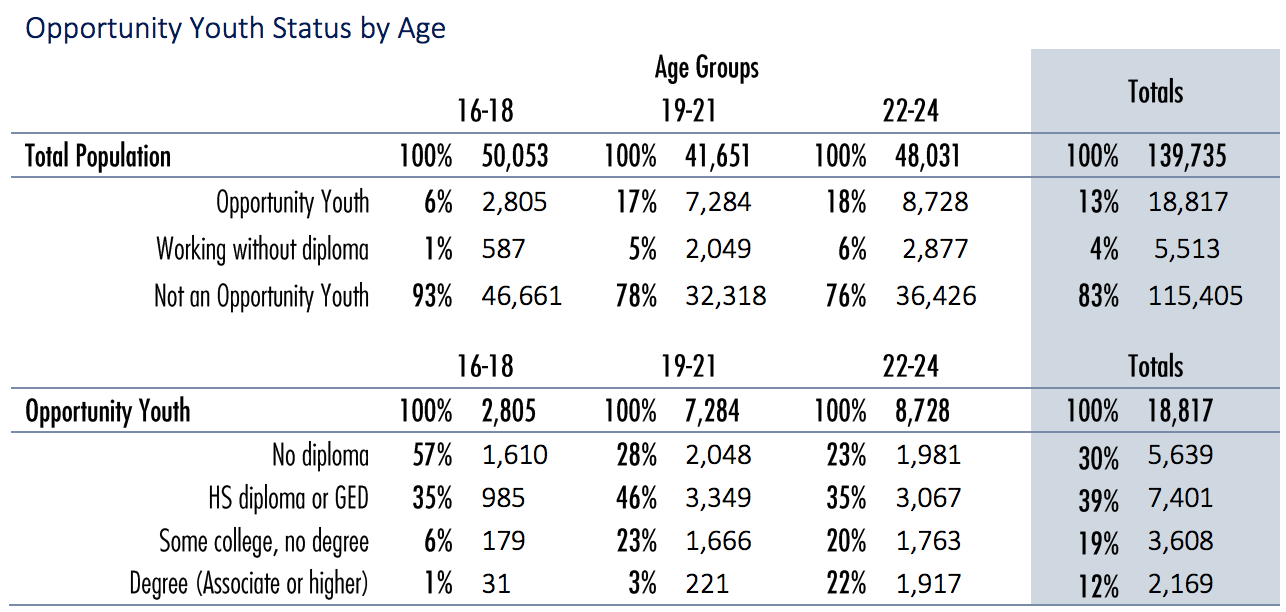

From this table, we can start to generate a list of the features and aggregations we need:

**Total Population:**
- [ ] Group ages into 3 groups (16-18, 19-21, 22-24) - Features:  'age'
- [ ] Calculate total population in SKC for each age group - Features:  'age'
- [ ] Calculate OY population in SKC for each age group - Features:  'age', 'employment_status', 'school_enrollment'
- [ ] Calculate Working without diploma population for each age group - Features:  'employment_status', 'education_attained'
- [ ] Calculate Non-OY population for each age group - Features:  subtract oy pop from total OR use 'employment_status', 'school_enrollment'
- [ ] Calculate totals and percentage of total pop. for each of the above - Features:  totals columns

**Opportunity Youth:**
- [ ] Use OY figures from Total Pop. table
- [ ] Calculate no diploma oy pop
- [ ] Calculate HS diploma or GED in oy pop
- [ ] Calculate some college, no degree in oy pop
- [ ] Calculate degree (associate or higher) in oy pop
- [ ] Calculate totals and percentages for the above

### Get the data:

Create a function to load the relevant data for South King County for ages between 16-24:

In [190]:
def skc_df():
    import psycopg2
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Establish DB:
    DBNAME = "opportunity_youth"

    # Create a connection to db
    conn = psycopg2.connect(dbname=DBNAME)
    
    skc_puma_codes = ['11613', '11614', '11615', '11612']
    
    QUERY = """
    SELECT rt AS record_type, serialno AS id, agep AS age, sex, st, pwgtp AS person_weight, puma, sch AS school_enrollment, schl AS education_attained, 
            esr AS employment_status, nwab AS absent_from_work, nwav AS avail_for_work, nwla AS layoff, nwlk AS look_for_work
    FROM pums_2017
    WHERE agep BETWEEN 16 AND 24"""

    relevant_ages_pums = pd.read_sql(QUERY, conn)
    skc_df = relevant_ages_pums[relevant_ages_pums['puma'].isin(skc_puma_codes)]    
    
    return skc_df

In [191]:
skc_df = skc_df()

In [192]:
skc_df

,record_type,id,age,sex,st,person_weight,puma,school_enrollment,education_attained,employment_status,absent_from_work,avail_for_work,layoff,look_for_work
32,P,2013000007063,19.0,1,53,30.0,11612,2,18,6,2,5,2,2
36,P,2013000008046,17.0,2,53,36.0,11613,2,13,6,2,5,2,2
48,P,2013000011255,17.0,2,53,13.0,11614,2,12,6,2,5,2,2
54,P,2013000012970,21.0,2,53,29.0,11612,3,18,6,2,5,2,2
57,P,2013000013525,18.0,2,53,24.0,11613,2,15,6,2,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37134,P,2017001386502,18.0,1,53,17.0,11613,1,11,6,3,5,3,3
37684,P,2017001464049,21.0,2,53,18.0,11613,1,16,6,3,5,3,3
37718,P,2017001470135,23.0,1,53,17.0,11613,1,14,6,3,5,3,3
38050,P,2017001518359,18.0,1,53,20.0,11613,1,11,6,3,5,3,3


In [193]:
# don't need this now as I am renaming columns on the sql level
# rename_columns = {'rt': 'record_type', 'serialno': 'id', 'puma': 'puma', 'agep': 'age', 'sex': 'sex', 'esr': 'employment_status', 
#                   'sch': 'school_enrollment', 'schl': 'education_attained', 'nwab': 'absent_from_work', 
#                   'nwav': 'avail_for_work', 'nwla': 'layoff', 'nwlk': 'look_for_work', 'pwgtp': 'person_weight'}

# skc_df.rename(columns = rename_columns, inplace = True)


This should be all the data we need in order to get our statistics. 

I'm now going to create sub-dataframes to break this information down into the relevant chunks.

### Creating age-group dataframes:
group_1 will be defined as ages 16-18

In [95]:
g1 = [16, 17, 18]

group_2 will be defined as ages 19-21

In [96]:
g2 = [19, 20, 21]

group_3 will be defined as ages 22-24

In [97]:
g3 = [22, 23, 24]

In [98]:
group_1 = skc_df[skc_df['age'].isin(g1)]

In [115]:
# Preview:
group_1.head()

,record_type,id,age,sex,st,person_weight,puma,school_enrollment,education_attained,employment_status,absent_from_work,avail_for_work,layoff,look_for_work
36,P,2013000008046,17.0,2,53,36.0,11613,2,13,6,2,5,2,2
48,P,2013000011255,17.0,2,53,13.0,11614,2,12,6,2,5,2,2
57,P,2013000013525,18.0,2,53,24.0,11613,2,15,6,2,5,2,2
159,P,2013000032921,18.0,1,53,16.0,11615,2,13,6,2,5,2,2
160,P,2013000032921,18.0,1,53,24.0,11615,3,18,6,2,5,2,2


In [99]:
group_2 = skc_df[skc_df['age'].isin(g2)]

In [116]:
# Preview:
group_2.head()

,record_type,id,age,sex,st,person_weight,puma,school_enrollment,education_attained,employment_status,absent_from_work,avail_for_work,layoff,look_for_work
32,P,2013000007063,19.0,1,53,30.0,11612,2,18,6,2,5,2,2
54,P,2013000012970,21.0,2,53,29.0,11612,3,18,6,2,5,2,2
93,P,2013000021239,19.0,1,53,91.0,11614,2,19,6,2,5,2,2
101,P,2013000022626,20.0,1,53,16.0,11615,2,19,3,2,1,2,1
158,P,2013000032921,21.0,1,53,17.0,11615,1,16,1,3,5,3,3


In [100]:
group_3 = skc_df[skc_df['age'].isin(g3)]

In [117]:
# Preview:
group_3.head()

,record_type,id,age,sex,st,person_weight,puma,school_enrollment,education_attained,employment_status,absent_from_work,avail_for_work,layoff,look_for_work
224,P,2013000047506,24.0,2,53,5.0,11615,1,16,1,3,5,3,3
234,P,2013000048962,22.0,2,53,25.0,11612,1,19,6,2,5,2,2
270,P,2013000056099,24.0,1,53,16.0,11613,1,17,1,2,5,2,2
327,P,2013000067168,24.0,2,53,22.0,11615,1,18,3,3,5,3,3
530,P,2013000102767,22.0,1,53,17.0,11615,3,21,1,3,5,3,3


Summing the person_weight for each group will give us an estimate of the population sizes for each age group:

In [102]:
pop_g1 = sum(group_1['person_weight'])
pop_g1

20635.0

In [103]:
pop_g2 = sum(group_2['person_weight'])
pop_g2

17702.0

In [104]:
pop_g3 = sum(group_3['person_weight'])
pop_g3

19579.0

Keep in mind that this is **not** the OY population - this is the total population of 16-24yo in South King County.

We can also easily get an estimate of the entire population in SKC of 16-24yos by simply summing the person_weights from skc_df:

In [112]:
total_pop_est = sum(skc_df['person_weight'])
total_pop_est

57916.0

### Creating OY dataframe:

I will wrap this up in a function again (note:  a pre-req of this function is that skc_df has to already be established):

In [106]:
def oy_df():
    # Codes relevant to unemployment and out of school:
    oy_employment_status = ['3', '6']
    oy_school_enrollment = ['1']
    oy_grade_attend = ['bb']
    
    # Create dataframe of just oy in skc:
    oy_df = skc_df[skc_df['employment_status'].isin(oy_employment_status) & skc_df['school_enrollment'].isin(oy_school_enrollment)]
    return oy_df

In [107]:
oy_df = oy_df()

In [108]:
# Preview data:
oy_df

,record_type,id,age,sex,st,person_weight,puma,school_enrollment,education_attained,employment_status,absent_from_work,avail_for_work,layoff,look_for_work
225,P,2013000047506,20.0,2,53,5.0,11615,1,16,6,2,5,2,2
234,P,2013000048962,22.0,2,53,25.0,11612,1,19,6,2,5,2,2
288,P,2013000058010,17.0,2,53,45.0,11614,1,13,6,2,5,2,2
327,P,2013000067168,24.0,2,53,22.0,11615,1,18,3,3,5,3,3
354,P,2013000070516,19.0,2,53,20.0,11612,1,16,6,2,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37025,P,2017001366540,23.0,2,53,21.0,11613,1,20,6,2,5,2,2
37134,P,2017001386502,18.0,1,53,17.0,11613,1,11,6,3,5,3,3
37684,P,2017001464049,21.0,2,53,18.0,11613,1,16,6,3,5,3,3
37718,P,2017001470135,23.0,1,53,17.0,11613,1,14,6,3,5,3,3


In [169]:
no_dip = oy_df[oy_df['education_attained'] == '15']

In [171]:
# OY Pop with no diploma:
no_dip_pop = no_dip['person_weight'].sum()

In [172]:
no_dip_pop

524.0

In [175]:
# turn this into a generic function
dip_ged_pop = oy_df[(oy_df['education_attained'] == '16') | (oy_df['education_attained'] == '17')]['person_weight'].sum()
dip_ged_pop

3323.0

Now I'll create dfs for each age group:  (might be over kill...)

In [123]:
oy_group_1 = oy_df[oy_df['age'].isin(g1)]

In [157]:
oy_group_1['age_group'] = 'Ages 16-18'

<ipython-input-157-1d1f3ede9ebb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oy_group_1['age_group'] = 'Ages 16-18'


In [124]:
oy_group_2 = oy_df[oy_df['age'].isin(g2)]

In [160]:
oy_group_2['age_group'] = 'Ages 19-21'

<ipython-input-160-a0aab010a6d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oy_group_2['age_group'] = 'Ages 19-21'


In [125]:
oy_group_3 = oy_df[oy_df['age'].isin(g3)]

In [176]:
oy_group_3.loc[:, 'age_group'] = 'Ages 22-24'

/opt/anaconda3/envs/oy-env/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [161]:
oy = oy_group_1.append([oy_group_2, oy_group_3])

In [162]:
oy

,record_type,id,age,sex,st,person_weight,puma,school_enrollment,education_attained,employment_status,absent_from_work,avail_for_work,layoff,look_for_work,age_group
288,P,2013000058010,17.0,2,53,45.0,11614,1,13,6,2,5,2,2,Ages 16-18
517,P,2013000100470,18.0,2,53,16.0,11613,1,13,3,3,5,3,3,Ages 16-18
1028,P,2013000204235,17.0,1,53,17.0,11613,1,13,6,2,5,2,2,Ages 16-18
1513,P,2013000303198,16.0,1,53,10.0,11613,1,15,6,2,5,2,2,Ages 16-18
4565,P,2013000916904,17.0,1,53,14.0,11614,1,01,6,2,5,2,2,Ages 16-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35648,P,2017001093903,24.0,2,53,3.0,11614,1,17,6,2,5,2,2,Ages 22-24
36808,P,2017001325124,24.0,1,53,36.0,11615,1,16,6,2,5,2,2,Ages 22-24
36876,P,2017001338622,24.0,2,53,23.0,11614,1,21,6,3,5,3,3,Ages 22-24
37025,P,2017001366540,23.0,2,53,21.0,11613,1,20,6,2,5,2,2,Ages 22-24


In [179]:
oy['new_col'] = 'val'

In [180]:
oy

,record_type,id,age,sex,st,person_weight,puma,school_enrollment,education_attained,employment_status,absent_from_work,avail_for_work,layoff,look_for_work,age_group,new_col
288,P,2013000058010,17.0,2,53,45.0,11614,1,13,6,2,5,2,2,Ages 16-18,val
517,P,2013000100470,18.0,2,53,16.0,11613,1,13,3,3,5,3,3,Ages 16-18,val
1028,P,2013000204235,17.0,1,53,17.0,11613,1,13,6,2,5,2,2,Ages 16-18,val
1513,P,2013000303198,16.0,1,53,10.0,11613,1,15,6,2,5,2,2,Ages 16-18,val
4565,P,2013000916904,17.0,1,53,14.0,11614,1,01,6,2,5,2,2,Ages 16-18,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35648,P,2017001093903,24.0,2,53,3.0,11614,1,17,6,2,5,2,2,Ages 22-24,val
36808,P,2017001325124,24.0,1,53,36.0,11615,1,16,6,2,5,2,2,Ages 22-24,val
36876,P,2017001338622,24.0,2,53,23.0,11614,1,21,6,3,5,3,3,Ages 22-24,val
37025,P,2017001366540,23.0,2,53,21.0,11613,1,20,6,2,5,2,2,Ages 22-24,val


In [164]:
oy.groupby(['age_group']).person_weight.sum()

age_group
Ages 16-18    1230.0
Ages 19-21    2541.0
Ages 22-24    2952.0
Name: person_weight, dtype: float64

### Creating non-OY dataframe:

In [109]:
oy_indexes = list(oy_df.index)

In [110]:
non_oy_df = skc_df.drop(oy_indexes)  # make sure inpalce = False so that skc_df is not changed

In [111]:
# Preview data:
non_oy_df

,record_type,id,age,sex,st,person_weight,puma,school_enrollment,education_attained,employment_status,absent_from_work,avail_for_work,layoff,look_for_work
32,P,2013000007063,19.0,1,53,30.0,11612,2,18,6,2,5,2,2
36,P,2013000008046,17.0,2,53,36.0,11613,2,13,6,2,5,2,2
48,P,2013000011255,17.0,2,53,13.0,11614,2,12,6,2,5,2,2
54,P,2013000012970,21.0,2,53,29.0,11612,3,18,6,2,5,2,2
57,P,2013000013525,18.0,2,53,24.0,11613,2,15,6,2,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37093,P,2017001378874,23.0,1,53,12.0,11613,2,16,1,3,5,3,3
37094,P,2017001378874,21.0,1,53,12.0,11613,2,16,1,3,5,3,3
37095,P,2017001378874,19.0,2,53,11.0,11613,2,14,1,3,5,3,3
37099,P,2017001379834,18.0,1,53,10.0,11615,2,14,6,2,5,2,2


In [166]:
#  Adding age_group category so that we can group by ages and run stats...
for item in non_oy_df:
    if non_oy_df['age'].isin(g1):
        non_oy_df['age_group'] = 'Ages 16-18'
    elif non_oy_df['age'].isin(g2):
        non_oy_df['age_group'] = 'Ages 19-21'
    elif non_oy_df['age'].isin(g3):
        non_oy_df['age_group'] = 'Ages 22-24'

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

### Aggregating our data:

Now that we have all the necessary sub-dataframes, we can start to generate our relevant statistics for our table.

When we want to generate statistics on the total 16-24 population, we will use the skc_df. 

When we want to generate statistics on the OY population, we will use the oy_df.

When we want to generate statistics on the non-OY population, we will use the non_oy_df.

#### Statistics:
There's a better way to do this since there's so much repetative code but for now it's a start - will refactor later. 

**Total Population:**

In [122]:
print(f'Total Pop. for ages 16-18: {pop_g1}\nTotal Pop. for ages 19-21: {pop_g2}\nTotal Pop. for ages 22-24: {pop_g3}\nTotal Pop. for ages 16-24: {total_pop_est}')

Total Pop. for ages 16-18: 20635.0
Total Pop. for ages 19-21: 17702.0
Total Pop. for ages 22-24: 19579.0
Total Pop. for ages 16-24: 57916.0


**Opportunity Youth Population:**

In [129]:
oy_pop_g1 = sum(oy_group_1['person_weight'])
oy_pop_g2 = sum(oy_group_2['person_weight'])
oy_pop_g3 = sum(oy_group_3['person_weight'])
oy_total_pop = sum(oy_df['person_weight'])

In [131]:
print(f'Total OY Pop. for ages 16-18: {oy_pop_g1}\nTotal OY Pop. for ages 19-21: {oy_pop_g2}\nTotal OY Pop. for ages 22-24: {oy_pop_g3}\nTotal OY Pop. for ages 16-24: {oy_total_pop}')

Total OY Pop. for ages 16-18: 1230.0
Total OY Pop. for ages 19-21: 2541.0
Total OY Pop. for ages 22-24: 2952.0
Total OY Pop. for ages 16-24: 6723.0
